# K Means Clustering

**Overview**

Online retail is a transntional dataset UK based retail company.This company sell all unique kind of occasion gift.Many customer of this comapany is wholesaler.

In [1]:
#Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# To scale data
from sklearn.preprocessing import scale

# To perform clustering
from sklearn.cluster import KMeans

In [3]:
df = pd.read_csv("Online_retail.csv",sep = ",",encoding = "ISO-8859-1",header = 0)

# Parse date
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"],format = "%d-%m-%Y %H:%M")

In [4]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [7]:
df.shape

(541909, 8)

In [8]:
#checking for null value
df.isna().values.any()

True

In [10]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [11]:
df.isna().sum()*100/df.shape[0]

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [12]:
# creating a copy dataset from the existing one
df_cpy = df.copy()

In [13]:
df_cpy.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

We can see from above analysis that there are huge amount of missing values in "Description" and "CustomerId" feaure..Each Customer ID holds important information about the specific customer..We can't do any imputation with "CustomerID" feature because any kind of misimputation may affect the model performance..

In [14]:
# Dropping the cells contains missing values

df_cpy = df.dropna()

In [15]:
df_cpy.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

# Extracting R(Recency), F(Frequency), M(Monetary) columns from the Data

In [17]:
# Extracting amount by multiplying quantity and unit price and save the data

amount = pd.DataFrame(df_cpy.Quantity * df_cpy.UnitPrice, columns = ["amount"])
amount.head()

,amount
0,15.30
1,20.34
2,22.00
3,20.34
4,20.34


## Monetary Value

In [18]:
# merging amount in order wise
df_cpy = pd.concat(objs = [df_cpy,amount],axis = 1, ignore_index = False)

##Monetary Function
#finding total amount spent per customer

monetary = df_cpy.groupby("CustomerID").amount.sum()
monetary = monetary.reset_index()
monetary.head()

,CustomerID,amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


## Frequency Value

In [20]:
frequency = df_cpy[["CustomerID","InvoiceNo"]]

# getting the count of order made by customer based on customer ID

freq = frequency.groupby("CustomerID").InvoiceNo.count()
freq = pd.DataFrame(freq)
freq = freq.reset_index()
freq.columns = ["CustomerID","Frequency"]
freq.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [21]:
# Merging  Amount and frequency column
#creating master dataset

master = monetary.merge(freq,on = "CustomerID",how = "inner")
master.head()

,CustomerID,amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


## Recency Value

In [22]:
recency = df_cpy[["CustomerID","InvoiceDate"]]
maximum = max(recency.InvoiceDate)

In [23]:
maximum

Timestamp('2011-12-09 12:50:00')

In [24]:
#Recency function
recency = df_cpy[["CustomerID","InvoiceDate"]]
maximum = max(recency.InvoiceDate)

#adding one more day to the max date so that the max date will have 1 as different and not zero.

maximum = maximum + pd.DateOffset(days = 1)
recency["diff"] = maximum - recency.InvoiceDate
recency.head()

C:\Users\ROBIN\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,CustomerID,InvoiceDate,diff
0,17850.0,2010-12-01 08:26:00,374 days 04:24:00
1,17850.0,2010-12-01 08:26:00,374 days 04:24:00
2,17850.0,2010-12-01 08:26:00,374 days 04:24:00
3,17850.0,2010-12-01 08:26:00,374 days 04:24:00
4,17850.0,2010-12-01 08:26:00,374 days 04:24:00


In [35]:
# recency by customerid
a = recency.groupby("CustomerID")

In [40]:
recency.groupby("CustomerID")["diff"].min()

CustomerID
12346.0   326 days 02:33:00
12347.0     2 days 20:58:00
12348.0    75 days 23:37:00
12349.0    19 days 02:59:00
12350.0   310 days 20:49:00
                 ...       
18280.0   278 days 02:58:00
18281.0   181 days 01:57:00
18282.0     8 days 01:07:00
18283.0     4 days 00:48:00
18287.0    43 days 03:21:00
Name: diff, Length: 4372, dtype: timedelta64[ns]

In [41]:
# merging dataframe by recency

dff = pd.DataFrame(recency.groupby("CustomerID")["diff"].min())
dff = dff.reset_index()
dff.columns = ["CustomerID","Recency"]
dff.head()

,CustomerID,Recency
0,12346.0,326 days 02:33:00
1,12347.0,2 days 20:58:00
2,12348.0,75 days 23:37:00
3,12349.0,19 days 02:59:00
4,12350.0,310 days 20:49:00


# RFM Combined Dataframe

In [42]:
RFM = freq.merge(monetary,on = "CustomerID")
RFM = RFM.merge(dff,on = "CustomerID")
RFM.head()

,CustomerID,Frequency,amount,Recency
0,12346.0,2,0.00,326 days 02:33:00
1,12347.0,182,4310.00,2 days 20:58:00
2,12348.0,31,1797.24,75 days 23:37:00
3,12349.0,73,1757.55,19 days 02:59:00
4,12350.0,17,334.40,310 days 20:49:00


# Outlier 

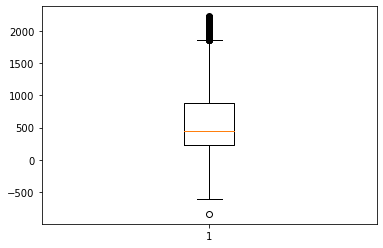

In [48]:
#outlier treatment for amount
plt.boxplot(RFM.amount)

Q1 = RFM.amount.quantile(0.25)
Q3 = RFM.amount.quantile(0.75)

IQR = Q3 - Q1

RFM = RFM[(RFM.amount >= Q1 - 1.5*IQR) & (RFM.amount <= Q3 + 1.5*IQR)]

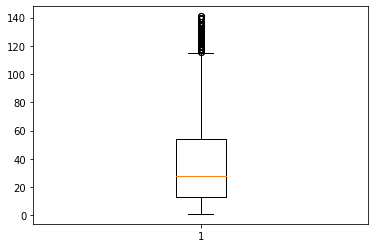

In [49]:
#Outlier treatment for Frequency

plt.boxplot(RFM.Frequency)

Q1 = RFM.Frequency.quantile(0.25)
Q3 = RFM.Frequency.quantile(0.75)

IQR = Q3 - Q1

RFM = RFM[(RFM.Frequency >= Q1 - 1.5*IQR) & (RFM.Frequency <= Q3 + 1.5*IQR)]

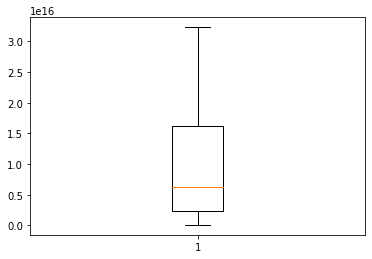

In [51]:
#Outlier treatment for Recency

plt.boxplot(RFM.Recency)

Q1 = RFM.Recency.quantile(0.25)
Q3 = RFM.Recency.quantile(0.75)

IQR = Q3 - Q1

RFM = RFM[(RFM.Recency >= Q1 - 1.5*IQR) & (RFM.Recency <= Q3 + 1.5*IQR)]

# Scaling the RFM Data

In [52]:
#Standardise parameter

RFM_norm = RFM.drop(["CustomerID"],axis = 1)
RFM_norm.Recency = RFM_norm.Recency.dt.days

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
RFM_norm = sc.fit_transform(RFM_norm)

In [53]:
RFM_norm = pd.DataFrame(RFM_norm)
RFM_norm.columns = ["Frequency","Amount","Recency"]
RFM_norm.head()

,Frequency,Amount,Recency
0,-1.180067,-1.259958,1.998309
1,-0.138618,2.807669,-0.364161
2,1.369686,2.717840,-0.891246
3,-0.641386,-0.503123,1.847713
4,2.159750,2.237711,-0.731238


# Hopkins Statistic

**Hopkin Stat** is a statistic that gives a value which indicate the cluster tendency.

* If the value is between {0.01....0.3} the data is regularly spaced.
* If the value is around 0.5 the data is random.
* If the value is between {0.7,....,0.99} the data has high tendency of Cluster. 

In [69]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan

def hopkins(X):
    d = X.shape[1]
    #d = len(columns)
    n = len(X) # len(rows)
    m = int(0.1 * n)
    nbars = NearestNeighbors(n_neighbors = 1).fit(X.values)
    
    rand_x = sample(range(0,n,1),m)
    
    ujd = []
    wjd = []
    
    for j in range(0,m):
        u_dist, _ = nbars.kneighbors(uniform(np.amin(X,axis = 0),np.amax(X,axis = 0),d).reshape(1,-1), 2, return_distance = True)
        ujd.append(u_dist[0][1])
        
        w_dist, _ = nbars.kneighbors(X.iloc[rand_x[j]].values.reshape(1,-1),2,return_distance = True)
        wjd.append(w_dist[0][1])
        
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    
    if isnan(H):
        print(ujd,wjd)
        H = 0
    return H

In [70]:
hopkins(RFM_norm)

0.841571837543632

# KMeans with some K

In [71]:
# Kmeans with 5 k

clus_model = KMeans(n_clusters = 5,max_iter = 50)
clus_model.fit(RFM_norm)

KMeans(max_iter=50, n_clusters=5)

# Silhoutte Analysis

In [72]:
from sklearn.metrics import silhouette_score

sse = []

for k in range(2,15):
    kmeans = KMeans(n_clusters = k).fit(RFM_norm)
    sse.append([k, silhouette_score(RFM_norm, kmeans.labels_)])

In [73]:
dss = pd.DataFrame(sse)
dss.head()

,0,1
0,2,0.393761
1,3,0.403283
2,4,0.361229
3,5,0.382720
4,6,0.343834


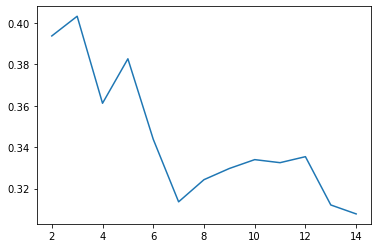

In [74]:
plt.plot(dss[0],dss[1])

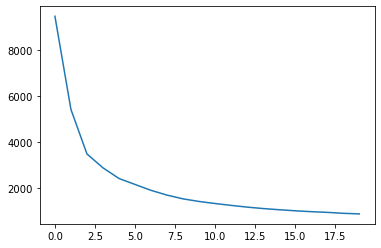

In [75]:
# Sum of Square Distance

ssd = []

for n_clus in list(range(1,21)):
    clust_model = KMeans(n_clusters = n_clus,max_iter = 50)
    clust_model.fit(RFM_norm)
    ssd.append(clust_model.inertia_)
    
plt.plot(ssd)

In [83]:
# Analysis of cluster formed

RFM.index = pd.RangeIndex(len(RFM.index))
RFM_km = pd.concat([RFM,pd.Series(clus_model.labels_)],axis = 1)
RFM_km.columns = ["CustomerID","Frequency","Amount","Recency","ClusterID"]

#RFM_km.head()
RFM_km.Recency = RFM_km.Recency.dt.days
km_cluster_amount = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Amount.mean())
km_cluster_freq = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Frequency.mean())
km_cluster_recency = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Recency.mean())


In [84]:
new_df = pd.concat([pd.Series([0,1,2,3,4]),km_cluster_amount,km_cluster_freq,km_cluster_recency],axis = 1)
new_df.columns = ["ClusterID","Amount_mean","Frequency_mean","Recency_mean"]
new_df.head()

,ClusterID,Amount_mean,Frequency_mean,Recency_mean
0,0,498.066644,78.505085,61.854237
1,1,278.820147,17.721612,266.826618
2,2,1421.572522,80.679525,50.572700
3,3,919.581168,40.349922,66.547434
4,4,294.852228,18.199252,58.925164


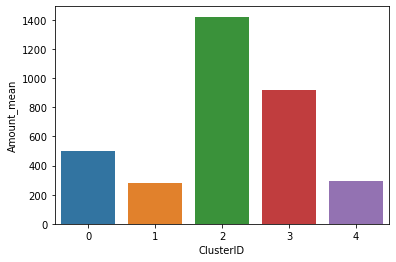

In [86]:
sns.barplot(x =new_df.ClusterID, y = new_df.Amount_mean)

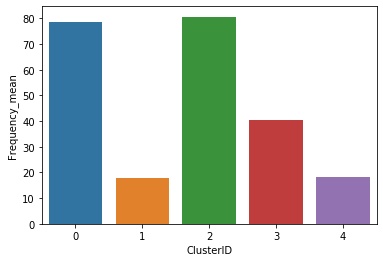

In [87]:
sns.barplot(x =new_df.ClusterID, y = new_df.Frequency_mean)

In [ ]:
sns.barplot(x =new_df.ClusterID, y = new_df.Amount_mean)